---
title: Validating reference gene expression prediction
author: Sabrina Mi
date: 9/6/2023
---

We are trying to replicate the Enformer result's in [Personal transcriptome variation is poorly explained by current genomic deep learning models, Huang et al](https://www.biorxiv.org/content/10.1101/2023.06.30.547100v1). They reported a 0.57 correlation in reference prediction across all genes. They used median GEUVADIS LCL gene expression data for their comparison and quantified predicted gene expression using the average of 10 bin window around each gene's TSS on the CAGE:B lymphoblastoid cell line track. I performed a similar analysis of Enformer performance along the reference genome, but instead I used a 3 bin window around the TSS and the CAGE:Brain, adult track to compare to observed GTEx brain cortex gene expression. I found 0.54 between predicted and observed reference gene expression. 

### Libraries and Definitions

In [4]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

enfref_dir = "/grand/TFXcan/imlab/users/lvairus/reftile_project/enformer-reference-epigenome"

def query_epigenome(chr_num, center_bp, n_bins=3, tracks=-1):
    """
    Parameters:
        path_to_enfref (str): path to the directory containing the concatenated reference enformer files
        chr_num (int/string): chromosome number
        center_bp (int): center base pair position (1-indexed)
        n_bins (int): number of bins to extract centered around center_bp (default: 896) 
            note: if the number of bins is even, the center bin will be in the second half of the array
        tracks (int list): list of tracks to extract (default: all 5313 tracks)

    Returns:
        epigen (np.array): enformer predictions centered at center_bp of shape (n_bins, len(tracks))
    """

    # from position choose center bin
    center_bin = center_bp // 128
    
    half_bins = n_bins // 2
    start_bin = center_bin - half_bins
    end_bin = center_bin + half_bins
    if n_bins % 2 != 0: # if n_bins is odd
        end_bin += 1

    with h5py.File(f"{enfref_dir}/chr{chr_num}_cat.h5", "r") as f:
        # get tracks if list provided
        if tracks == -1:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, :] 
        else:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, tracks] 

    return epigen

In [5]:
## create lists of genes on each chromomsome
hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", header=0, sep="\t")
gene_dict = hg38_annot.groupby('chromosome_name')['ensembl_gene_id'].apply(list).to_dict()

In [3]:
## Initialize lists of CAGE predictions for each gene
hg38_annot.set_index("ensembl_gene_id", inplace=True)
chr_list = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "X"]
CAGE_predictions = {key: [] for key in chr_list}

### Query Enformer predicted gene expression

In [ ]:
## Function to put CAGE predictions in list (in the same order as gene list by chromosome)
for chr in chr_list:
    gene_list = gene_dict[chr]
    for gene in gene_list:
        bins = query_epigenome(chr, hg38_annot.loc[gene]['transcription_start_site'], num_bins=10, tracks=[5110])
        CAGE_predictions[chr].append(np.average(bins))

### Calculate GEUVADIS reference gene expression

In [62]:
geuvadis_gex = pd.read_csv("/lus/grand/projects/TFXcan/imlab/data/1000G/expression/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz", sep="\t")
geuvadis_gex.head()

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
0,ENSG00000152931.6,ENSG00000152931.6,5,59783540,0.101858,0.078110,0.048981,0.118597,0.004035,0.010925,...,0.088601,0.240010,0.137175,0.148494,0.038643,0.088509,0.029204,0.024423,0.044816,0.139186
1,ENSG00000183696.9,ENSG00000183696.9,7,48128225,8.183805,5.686911,2.434653,3.830894,6.612288,4.709646,...,13.428205,6.094500,12.536000,2.217262,3.573394,7.583364,4.052882,1.570378,4.900372,6.737308
2,ENSG00000139269.2,ENSG00000139269.2,12,57846106,1.199910,1.573572,0.521616,1.447225,3.565791,1.982681,...,3.225880,1.996067,2.854923,2.267343,1.331201,2.187895,1.004250,3.003316,1.984362,1.684954
3,ENSG00000169129.8,ENSG00000169129.8,10,116164515,0.831940,0.069778,0.931086,0.620941,1.660668,0.570481,...,1.023381,1.127852,0.774409,1.495854,0.895342,1.513521,0.826377,1.021201,0.952502,0.740565
4,ENSG00000134602.11,ENSG00000134602.11,X,131157293,27.646422,24.395572,16.445374,24.806650,25.113349,19.233988,...,25.079490,28.725528,24.450520,27.264069,26.912814,29.509210,26.462331,25.624009,25.707741,22.824957


In [21]:
geuvadis_gex['TargetID'] = geuvadis_gex['TargetID'].apply(lambda gene: gene.split('.')[0])
geuvadis_gex.set_index('TargetID', inplace=True)
# Calculate average gene expression
geuvadis_mean_gex = geuvadis_gex.drop(columns=['Gene_Symbol', 'Chr', 'Coord']).mean(axis=1)
geuvadis_mean_gex.name = 'geuvadis'

### Plot correlation across genes

In [22]:
merged_dict = {chr: pd.DataFrame(index=gene_dict[chr]) for chr in chr_list}
for chr in chr_list:
    merged_dict[chr]['enformer'] = CAGE_predictions[chr]

In [23]:
for chr in chr_list:
    gene_list = merged_dict[chr].index.intersection(geuvadis_gex.index)
    merged_dict[chr] = merged_dict[chr].merge(geuvadis_mean_gex, left_index=True, right_index=True, how='inner').dropna()

In [25]:
all_genes = pd.concat(merged_dict.values())
all_genes.to_csv("/home/s1mi/enformer_rat_data/output/hg38_predicted_vs_observed_expression_GEUVADIS.csv")

In [26]:
print(all_genes)

                  enformer   geuvadis
ENSG00000157911  26.583872   7.754189
ENSG00000142655  45.931610  11.007757
ENSG00000149527   0.106181   0.541469
ENSG00000171621   8.679342   1.851198
ENSG00000142583  44.758301  15.652001
...                    ...        ...
ENSG00000169239  16.344961   2.933672
ENSG00000102181  24.281412  11.087266
ENSG00000169083   0.381008   0.021671
ENSG00000147050  58.424080  10.937074
ENSG00000101972  36.190773  29.675127

[14585 rows x 2 columns]


Correlation across all hg38 genes: 0.19324818461902257


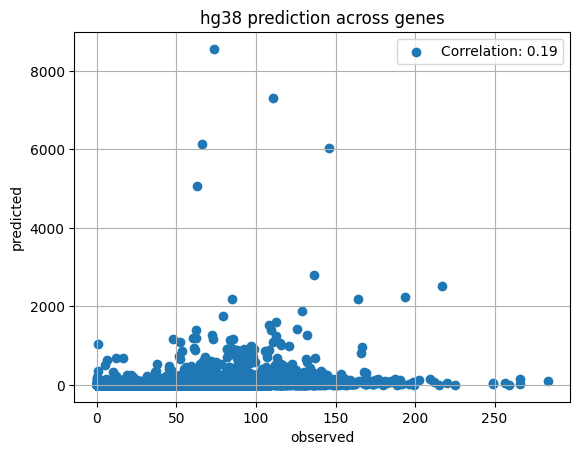

In [28]:
corr = all_genes.corr().iloc[0,1]
print("Correlation across all hg38 genes:", corr)
plt.scatter(all_genes['enformer'], all_genes['geuvadis'], label=f'Correlation: {corr:.2f}')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title("hg38 prediction across genes")
plt.legend()
plt.grid(True)
plt.show()

### Compare to 3 bin window predictions

In [40]:
import time
for chr in chr_list:
    tic = time.perf_counter()
    gene_list = merged_dict[chr].index
    predictions = []
    for gene in gene_list:
        bins = query_epigenome(chr, hg38_annot.loc[gene]['transcription_start_site'], num_bins=3, tracks=[5110])
        predictions.append(np.average(bins))
    merged_dict[chr]["enformer, 3 bin"] = predictions
    toc = time.perf_counter()
    print("Querying chromosome", chr, "genes...,", toc - tic, "seconds")

Querying chromosome 1 genes..., 44.38094838405959 seconds
Querying chromosome 2 genes..., 35.90561124891974 seconds
Querying chromosome 3 genes..., 31.244477248983458 seconds
Querying chromosome 4 genes..., 24.72689785005059 seconds
Querying chromosome 5 genes..., 25.695796379004605 seconds
Querying chromosome 6 genes..., 27.095260299975052 seconds
Querying chromosome 7 genes..., 29.503782182000577 seconds
Querying chromosome 8 genes..., 16.569634438026696 seconds
Querying chromosome 9 genes..., 17.30759223003406 seconds
Querying chromosome 10 genes..., 21.247902504052036 seconds
Querying chromosome 11 genes..., 31.04979562200606 seconds
Querying chromosome 12 genes..., 23.60031519201584 seconds
Querying chromosome 13 genes..., 10.305076834047213 seconds
Querying chromosome 14 genes..., 15.184288493008353 seconds
Querying chromosome 15 genes..., 16.564520464045927 seconds
Querying chromosome 16 genes..., 16.226559089962393 seconds
Querying chromosome 17 genes..., 20.44110699906014 seco

In [41]:
all_genes = pd.concat(merged_dict.values())
all_genes = all_genes[["geuvadis", "enformer", "enformer, 3 bin"]]
all_genes.rename(columns={'enformer': 'enformer, 10 bin'}, inplace=True)
all_genes.to_csv("/home/s1mi/enformer_rat_data/output/hg38_predicted_vs_observed_expression_GEUVADIS.csv")

I'm really not sure why I can't get near the 0.57 expected correlation, so I will run the original code used by Huang et al.

### Original Code

I cloned [personalized-expression-benchmark](https://github.com/ni-lab/personalized-expression-benchmark.git).

The first difference I noticed in their analysis is that they subset to 3259 genes in the GEUVADIS EUR dataset found to have at least one significant cis-eQTL.

In [18]:
import numpy as np
import pandas as pd
all_genes = pd.read_csv("/home/s1mi/enformer_rat_data/output/hg38_predicted_vs_observed_expression_GEUVADIS.csv", index_col = 0)

In [22]:
eqtl_genes = pd.read_csv("/home/s1mi/Github/personalized-expression-benchmark/data/gene_list.csv", usecols=[0], header=None)

In [29]:
print(eqtl_genes[0].to_list())

['ENSG00000000457', 'ENSG00000001630', 'ENSG00000002549', 'ENSG00000002745', 'ENSG00000003056', 'ENSG00000003249', 'ENSG00000003402', 'ENSG00000004660', 'ENSG00000005075', 'ENSG00000005156', 'ENSG00000005700', 'ENSG00000005882', 'ENSG00000006075', 'ENSG00000006114', 'ENSG00000006194', 'ENSG00000006282', 'ENSG00000006607', 'ENSG00000006695', 'ENSG00000007255', 'ENSG00000007341', 'ENSG00000008382', 'ENSG00000008517', 'ENSG00000008988', 'ENSG00000010270', 'ENSG00000010278', 'ENSG00000010310', 'ENSG00000010361', 'ENSG00000010626', 'ENSG00000011052', 'ENSG00000011105', 'ENSG00000011295', 'ENSG00000011376', 'ENSG00000011422', 'ENSG00000011478', 'ENSG00000011566', 'ENSG00000011638', 'ENSG00000012124', 'ENSG00000012779', 'ENSG00000013016', 'ENSG00000013288', 'ENSG00000013374', 'ENSG00000013503', 'ENSG00000013561', 'ENSG00000013583', 'ENSG00000014138', 'ENSG00000014164', 'ENSG00000014257', 'ENSG00000015479', 'ENSG00000018699', 'ENSG00000018869', 'ENSG00000020922', 'ENSG00000021300', 'ENSG000000

In [45]:
eqtl_predictions = all_genes[all_genes.index.isin(eqtl_genes[0])]
print(eqtl_predictions.shape[0], "genes in correlation test")
eqtl_predictions.corr()

2853 genes in correlation test


,geuvadis,"enformer, 10 bin","enformer, 3 bin"
geuvadis,1.000000,0.304581,0.321576
"enformer, 10 bin",0.304581,1.000000,0.919356
"enformer, 3 bin",0.321576,0.919356,1.000000


This is slightly better, but a couple hundred genes got dropped somewhere along the way? 

### Original Code

My only modification was hard-coding paths and removing the fasta folder argument in [`personalized-expression-benchmark/enformer/run_enformer_reference.py`](https://github.com/ni-lab/personalized-expression-benchmark/blob/main/enformer/run_enformer_reference.py)

```
module load conda
conda activate ml-python
cd /home/s1mi/Github/personalized-expression-benchmark

python3 enformer/run_enformer_reference.py . data/gene_list.csv

```